In [3]:
from PKRP import  PolyKernelRandomProjection

In [4]:
# Load and scale MNIST data

from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(-1,28*28)/128. - 1
X_test = X_test.reshape(-1,28*28)/128. - 1

Using Theano backend.


### Experiments on classification accuracy

In [6]:
%timeit pkrp.transform(X_train, ver2=True)

1 loop, best of 3: 3.26 s per loop


In [7]:
%timeit pkrp.transform(X_train, ver2=False)

1 loop, best of 3: 3.3 s per loop


In [19]:
from sklearn.model_selection import  train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Normalizer, StandardScaler

from sklearn.svm import LinearSVC, SVC

In [20]:
# Linear SVM accuracy (91-92%)
# Can be improved a bit by StandardScalling and adjusting C

lsvm = LinearSVC(C=.5).fit(X_train, Y_train)
print lsvm.score(X_test, Y_test) 

0.9167


In [5]:
# PolyKernelRandomProjection + Linear SVM accuracy (97-98%)
# An appropiate C value must be selected for each case. Satandard-Scalling may be used between the projection and the SVM.

pkrp_svm = Pipeline([("kRP", PolyKernelRandomProjection(n_components=2000, p=488, t=10, degree=2)),
                     #("standarize", StandardScaler()),
                     ("SVM", LinearSVC(C=5e-5))
                    ])

pkrp_svm.fit(X_train, Y_train)
print pkrp_svm.score(X_test, Y_test)

0.973


In [4]:
# Poly-kernel SVM accuracy (aprx. 98%)

svm = SVC(C=0.5, kernel="poly", gamma=1., degree=2, coef0=0).fit(  X_train, Y_train)
print svm.score(X_test, Y_test)

0.9784


In [3]:
# P-RP
from sklearn.base import BaseEstimator,TransformerMixin
from numba import jit
from numpy import sqrt
from sklearn import random_projection 

class PRP( BaseEstimator, TransformerMixin):
    
    projectionMatrix = None
    
    def __init__(self, n_components=100, s=1, t=20):
        
        self.n_components = n_components
        self.s = s
        self.t = t

    
    def fit(self, X, y=None):
        self.projectionMatrix = fast_generateRs(X, self.t, self.n_components, s=self.s)
        self.projectionMatrix = self.projectionMatrix.astype(np.float64)
    
        return self
    

    def transform(self, X, y=None):
        return fast_randomProjection_n(X, self.projectionMatrix)/sqrt(self.n_components)

@jit(nopython=True)
def fast_randomProjection_n(X, Rs):
    Xrp = np.zeros(shape=(X.shape[0], Rs.shape[1]))
    #X2 = X**2
    #Rs2 = Rs**2
    
    for r in range(Rs.shape[0]/2):
        Xrp += np.dot(X, Rs[r].T)**2 #- np.dot(X2, Rs2[r].T)
    for r in range(Rs.shape[0]/2):
        Xrp -= np.dot(X, Rs[r+Rs.shape[0]/2].T)**2 # - np.dot(X2, Rs2[r].T)
    return Xrp

def fast_generateRs(X, nRs, n_comp,s):

    return sqrt(s)*np.random.choice([-1,0,1], p=[.5/s, 1-1./s, .5/s], size=(nRs,n_comp, X.shape[1]))/sqrt(sqrt(2*nRs))

def generateRs(X, nRs, n_comp, s):
    r = sqrt(nRs)/float(nRs)
    Rs = []
    for i in range(nRs):
        Rpn = random_projection.SparseRandomProjection(n_components=n_comp, density=1./s)
        Rpn.fit(X)
        Rn = Rpn.components_*sqrt(n_comp)*sqrt(r/sqrt(2.0))
        Rs.append(Rn)
    return np.asarray(Rs)

## Experiments on distance preservation

In [21]:
X_test_small = X_test[0:500]
X_test = X_test[500:]


In [23]:
# Compute the pairwise distance matrix in the kernel feature space for the degree-two homogeneous poly kernel
# K = <x,y>^2
# Distances in the kernel feature space can be computed as Dxy = K(x,x) + K(y,y) - 2 K(x,y)

import numpy as np

c = 100
d = 3

Kxx = (np.sum(X_test_small**2, axis=1)+c)**d
Kxx = Kxx.reshape((500,1))

Kyy = (np.sum(X_test**2, axis=1)+c)**d
Kyy = Kyy.reshape((X_test.shape[0], 1))

Kxy = (np.dot(X_test_small, X_test.T)+c)**d

D = np.zeros((500, X_test.shape[0]))
D += Kxx 
D += Kyy.T
D += -2*Kxy

In [24]:
c=100

X_test_small_c = np.concatenate([X_test_small, np.sqrt(c)*np.ones((X_test_small.shape[0], 1))], axis=1)
X_test_c = np.concatenate([X_test, np.sqrt(c)*np.ones((X_test.shape[0], 1))], axis=1)

krp =  PolyKernelRandomProjection(degree=3, n_components=500, t=200, s=10, gaussian=False, minimize_repetition=True, p=10000).fit(X_test_small_c)

X_pkrp_small = krp.transform(X_test_small_c)
X_pkrp = krp.transform(X_test_c)
D_pkrp = pairwise_distances(X_pkrp_small, X_pkrp)**2

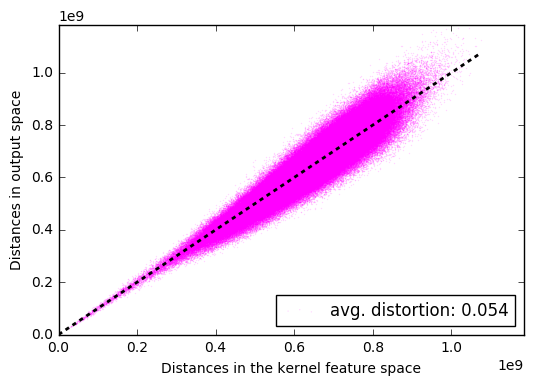

In [26]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

n_points = 500*1000
# Plot distances in the kernel feature space against distances in the output representation
# Also compute the average relative distortion

avgdist = np.nanmean(np.divide(np.abs(D_pkrp - D), D))
plt.scatter(D.ravel()[:n_points], D_pkrp.ravel()[:n_points], s=1, alpha=0.15, c="magenta", linewidths=0)
plt.legend(["avg. distortion: %.3f"%avgdist], loc="lower right")
plt.plot([0,np.max(D)],[0,np.max(D)], c="black", linewidth=2, dashes=[3,3])
plt.xlim([0, np.max(D)*1.1])
plt.ylim([0, np.max(D)*1.1])
plt.xlabel("Distances in the kernel feature space")
plt.ylabel("Distances in output space")

plt.show()

In [9]:
# Use this to create the GIF in the repo

#avgdistList = []
#ncomLis = []
#
#
#from pylab import rcParams
#rcParams['figure.figsize'] = 10, 4
#
#plt.subplots_adjust(wspace=2)
#plt.figure()
#
#for i in range(5, 500):
#    print i
#    temp = []
#    for j in range(1,4):
#
#        X_pkrp = PolyKernelRandomProjection(n_components=i, p=5000, t=20, degree=2).fit_transform(X_test_small)
#        D_pkrp = pairwise_distances(X_pkrp)**2
#
#
#        plt.subplots_adjust(wspace=2)
#        ax1 = plt.subplot(1,2,1)
#        
#        ax1.set_title("n_components = %d"%i)
#        avgdist = np.nanmean(np.divide(np.abs(D_pkrp - D), D))
#        temp.append(avgdist)
#        ax1.scatter(D.ravel(), D_pkrp.ravel(), s=1, alpha=0.15, c="magenta", linewidths=0)
#        ax1.legend(["avg. distortion: %.3f"%avgdist], loc="lower right", markerscale=0,handletextpad=-2.0)
#        ax1.plot([0,np.max(D)],[0,np.max(D)], c="black", linewidth=2, dashes=[3,3])
#        ax1.set_xlim([0, np.max(D)*1.1])
#        ax1.set_ylim([0, np.max(D)*1.1])
#        ax1.set_xlabel("Pairwise distances in the kernel feature space")
#        ax1.set_ylabel("Pairwise distances in output space")
#        
#        ax2 = plt.subplot(1,2,2)
#       
#    
#        #avgdist = np.nanmean(np.divide(np.abs(D_pkrp - D), D))
#        #ax2.legend(["avg. distortion: %.2f"%avgdist], loc="lower right")
#        ax2.plot(ncomLis, avgdistList, c="red", linewidth=2)
#        ax2.set_xlim([4, 250])
#        ax2.set_ylim([0, .55])
#        ax2.set_xlabel("n_components")
#        ax2.set_ylabel("Avg. distortion")
#        
#        plt.tight_layout()
#
#        #plt.show()
#        plt.savefig("bfig_%04d_%02d.png"%(i,j))
#        plt.clf()
#    
#    ncomLis.append(i)
#    avgdistList.append(np.mean(temp))